In [98]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

FG_FILE = "fear_greed_index.csv"     # bitcoin sentiment file 
HIST_FILE = "historical_data.csv"    # hyperliquid trades file 
OUT_DIR = "analysis_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

In [100]:
def find_col(df, candidates):
    for cand in candidates:
        for c in df.columns:
            if c == cand or c.lower() == cand.lower():
                return c
    return None

def two_proportion_z_test(success_a, nobs_a, success_b, nobs_b):
    p1 = success_a / nobs_a
    p2 = success_b / nobs_b
    p_pool = (success_a + success_b) / (nobs_a + nobs_b)
    se = math.sqrt(p_pool * (1 - p_pool) * (1 / nobs_a + 1 / nobs_b))
    if se == 0:
        return np.nan, np.nan
    z = (p1 - p2) / se
    p = 2 * (1 - stats.norm.cdf(abs(z)))
    return z, p


In [101]:
print("Working dir files (first 50):", os.listdir(".")[:50])
if not os.path.exists(FG_FILE):
    raise FileNotFoundError(f"{FG_FILE} not found.")
if not os.path.exists(HIST_FILE):
    raise FileNotFoundError(f"{HIST_FILE} not found.")

fg = pd.read_csv(FG_FILE)
hist = pd.read_csv(HIST_FILE)
print(f"Loaded FG rows={len(fg):,}, HIST rows={len(hist):,}")


Working dir files (first 50): ['.anaconda', '.cache', '.conda', '.condarc', '.continuum', '.ipynb_checkpoints', '.ipython', '.jupyter', '.keras', '.matplotlib', '.ollama', '.streamlit', '.vscode', '01-SF Salaries Exercise.ipynb', 'Accredian Assignment.ipynb', 'anaconda3', 'anaconda_projects', 'analysis_outputs', 'ANN DL.ipynb', 'AppData', 'Application Data', 'articles', 'artifacts', 'assessment_artifacts', 'blackcoffer_assignment.ipynb', 'blackcoffer_assignment.py', 'cleaned_movie_ratings.csv', 'Contacts', 'Cookies', 'dataset', 'Desktop', 'diagrams', 'Documents', 'Downloads', 'Favorites', 'fear_greed_index.csv', 'Fraud.csv', 'Heart_desies_dataset.csv', 'historical_data.csv', 'image_2025_03_05T10_45_04_826Z.png', 'Input.xlsx', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'LR.ipynb', 'marketing_dataset', 'marketing_multi_agent_dataset', 'marketing_multi_agent_dataset_v1_final', 'marketing_multi_agent_dataset_v1_final.zip', 'Music']
Loaded FG rows=2,644, HIST rows=211,224


In [102]:
fg_date_col = find_col(fg, ["date", "Date", "datetime", "timestamp"])
fg_class_col = find_col(fg, ["classification", "Classification", "sentiment", "label"])
fg_value_col = find_col(fg, ["value", "score"])

if fg_date_col is None:
    raise ValueError("No date column detected in Fear/Greed file. Please ensure it has a date column.")

# parse date
fg = fg.copy()
fg[fg_date_col] = pd.to_datetime(fg[fg_date_col], errors="coerce")
fg = fg.dropna(subset=[fg_date_col]).reset_index(drop=True)

# ensure classification exists; if not, derive from value
if fg_class_col is None:
    if fg_value_col is not None:
        print("No classification column in FG file — deriving from numeric value column.")
        fg['classification'] = pd.cut(pd.to_numeric(fg[fg_value_col], errors='coerce'),
                                      bins=[-1,25,50,75,101],
                                      labels=['Fear','Neutral','Greed','Extreme Greed'])
        fg_class_col = 'classification'
    else:
        raise ValueError("Fear/Greed file missing classification and numeric value.")

fg = fg.sort_values(by=fg_date_col).reset_index(drop=True)
fg['fg_dt'] = fg[fg_date_col]
fg['fg_date_floor'] = fg['fg_dt'].dt.floor('D')
print("FG date range:", fg['fg_dt'].min(), "to", fg['fg_dt'].max())


FG date range: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


In [103]:
hist_time_col = find_col(hist, ["Timestamp IST", "Timestamp", "timestamp", "time", "Time", "Datetime", "date"])
if hist_time_col is None:
    raise ValueError("Could not detect a timestamp column in historical_data.csv.")

hist = hist.copy()
hist_raw = hist[hist_time_col]
hist_numeric = pd.to_numeric(hist_raw, errors='coerce')

def infer_unit_and_parse(num_series, raw_series):
    if not num_series.dropna().empty:
        med = float(np.median(num_series.dropna()))
        if med > 1e11:
            return pd.to_datetime(num_series, unit='ms', errors='coerce'), 'ms'
        if med > 1e9:
            return pd.to_datetime(num_series, unit='s', errors='coerce'), 's'
    parsed = pd.to_datetime(raw_series.astype(str), errors='coerce')
    if not parsed.dropna().empty and parsed.dt.year.between(2009,2035).any():
        return parsed, 'str'
    parsed = pd.to_datetime(num_series, unit='ms', errors='coerce')
    if not parsed.dropna().empty:
        return parsed, 'ms'
    parsed = pd.to_datetime(num_series, unit='s', errors='coerce')
    return parsed, 's'

parsed_times, parsed_unit = infer_unit_and_parse(hist_numeric, hist_raw)
hist['trade_time'] = parsed_times
print("Parsed trade_time method:", parsed_unit)

hist = hist.dropna(subset=['trade_time']).reset_index(drop=True)
hist['trade_time_floor'] = hist['trade_time'].dt.floor('D')
print("Hist trade_time range:", hist['trade_time'].min(), "to", hist['trade_time'].max())


Parsed trade_time method: str
Hist trade_time range: 2023-01-05 01:06:00 to 2025-12-04 23:55:00


In [104]:
fg_for_merge = fg[['fg_date_floor', fg_class_col]].copy()
fg_for_merge = fg_for_merge.groupby('fg_date_floor')[fg_class_col].last().reset_index()
fg_for_merge = fg_for_merge.sort_values('fg_date_floor').dropna(subset=['fg_date_floor'])

hist_sorted = hist.sort_values('trade_time_floor').dropna(subset=['trade_time_floor'])

merged = pd.merge_asof(
    left=hist_sorted,
    right=fg_for_merge,
    left_on='trade_time_floor',
    right_on='fg_date_floor',
    direction='backward'
)
merged = merged.rename(columns={fg_class_col: 'fg_classification'})

mapped_count = merged['fg_classification'].notna().sum()
print(f"Trades mapped to sentiment: {mapped_count:,} / {len(merged):,}")

merged.to_csv(os.path.join(OUT_DIR, "merged_trades_with_sentiment.csv"), index=False)


Trades mapped to sentiment: 79,225 / 79,225


In [105]:
closedpnl_col = find_col(merged, ["Closed PnL","closedPnL","pnl","PnL","realizedPnl"])
account_col = find_col(merged, ["Account","account","user"])
symbol_col  = find_col(merged, ["Coin","coin","Symbol","symbol"])
leverage_col = find_col(merged, ["leverage","Leverage"])

print("Detected columns:", closedpnl_col, account_col, symbol_col, leverage_col)

if closedpnl_col:
    merged['closedPnL_num'] = pd.to_numeric(merged[closedpnl_col], errors='coerce')
else:
    merged['closedPnL_num'] = np.nan

agg_by_sent = merged.groupby('fg_classification').agg(
    num_trades=('closedPnL_num','count'),
    total_closedPnL=('closedPnL_num','sum'),
    mean_closedPnL=('closedPnL_num','mean'),
    median_closedPnL=('closedPnL_num','median'),
    positive_trades=('closedPnL_num', lambda s: (s>0).sum())
).reset_index()

agg_by_sent['win_rate'] = agg_by_sent['positive_trades'] / agg_by_sent['num_trades'].replace({0:np.nan})
agg_by_sent.to_csv(os.path.join(OUT_DIR, "agg_by_sentiment.csv"), index=False)
print(agg_by_sent)


Detected columns: Closed PnL Account Coin None
  fg_classification  num_trades  total_closedPnL  mean_closedPnL  \
0      Extreme Fear        2326       4,399.9366          1.8916   
1     Extreme Greed        5621   1,156,893.6756        205.8163   
2              Fear       13869   1,779,225.5827        128.2880   
3             Greed       54653   2,663,789.0958         48.7400   
4           Neutral        2756      74,656.7420         27.0888   

   median_closedPnL  positive_trades  win_rate  
0            0.0000              681    0.2928  
1            0.9605             3110    0.5533  
2            0.0000             5295    0.3818  
3            0.0000            23012    0.4211  
4            0.0000             1364    0.4949  


In [106]:
fear_pnl = merged[merged['fg_classification'].str.contains('Fear', case=False, na=False)]['closedPnL_num'].dropna()
greed_pnl = merged[merged['fg_classification'].str.contains('Greed', case=False, na=False)]['closedPnL_num'].dropna()

if len(fear_pnl) > 0 and len(greed_pnl) > 0:
    u_stat, p_val = stats.mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
    print(f"Mann-Whitney U: U={u_stat:.2f}, p={p_val:.6f}")


Mann-Whitney U: U=463036970.00, p=0.000000


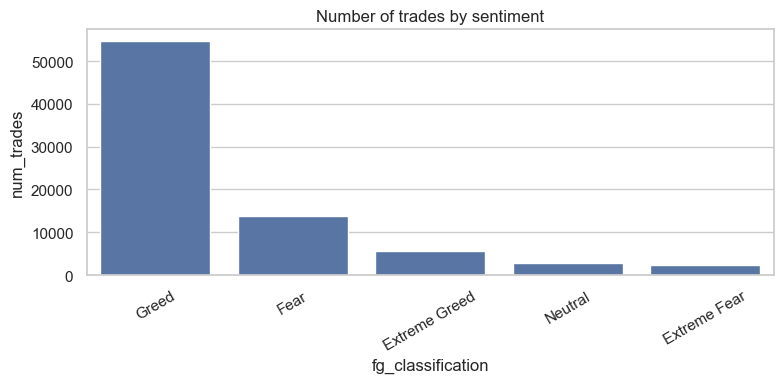

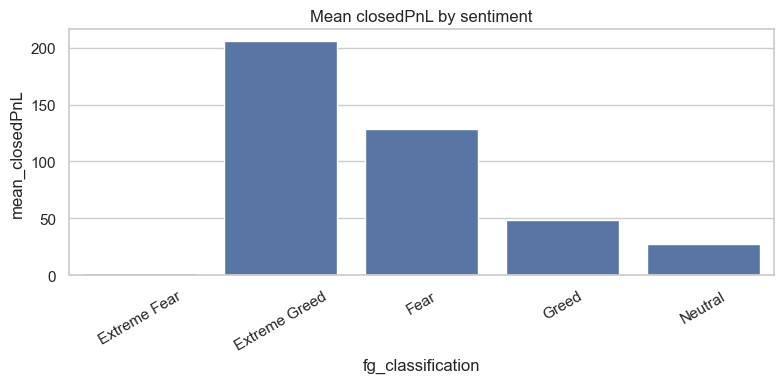

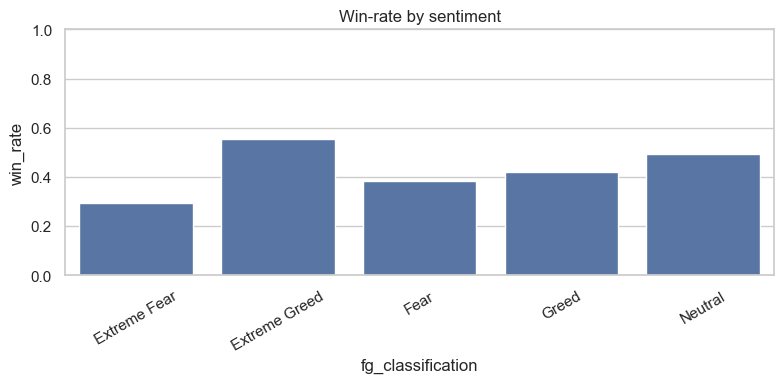

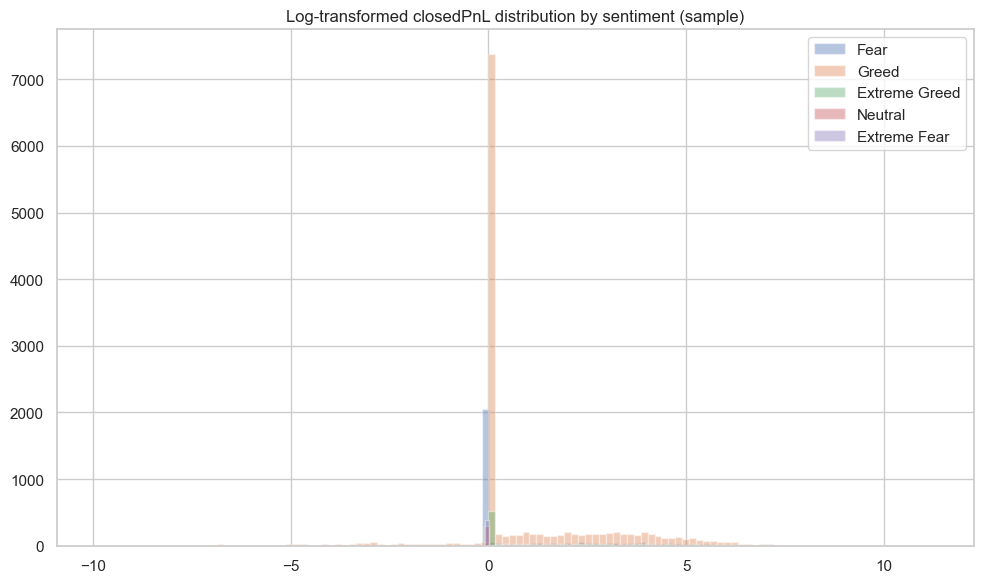

In [107]:
sns.set(style="whitegrid")

# 1) Number of trades by sentiment
if len(agg_by_sent)>0:
    plt.figure(figsize=(8,4))
    sns.barplot(x='fg_classification', y='num_trades', data=agg_by_sent.sort_values('num_trades', ascending=False))
    plt.title("Number of trades by sentiment")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"plot_trades_by_sentiment.png"))
    plt.show()

# 2) Mean PnL by sentiment
plt.figure(figsize=(8,4))
sns.barplot(x='fg_classification', y='mean_closedPnL', data=agg_by_sent)
plt.title("Mean closedPnL by sentiment")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"plot_mean_pnl_by_sentiment.png"))
plt.show()

# 3) Win-rate by sentiment
plt.figure(figsize=(8,4))
sns.barplot(x='fg_classification', y='win_rate', data=agg_by_sent)
plt.title("Win-rate by sentiment")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"plot_winrate_by_sentiment.png"))
plt.show()

# 4) Distribution of closedPnL (log1p transform) by sentiment (sample to avoid huge plots)
sample = merged.dropna(subset=['closedPnL_num','fg_classification'])
if len(sample) > 20000:
    sample = sample.sample(20000, random_state=42)
plt.figure(figsize=(10,6))
for cls in sample['fg_classification'].unique():
    vals = sample.loc[sample['fg_classification']==cls, 'closedPnL_num'].dropna()
    if len(vals)>0:
        plt.hist(np.sign(vals)*np.log1p(np.abs(vals)), bins=120, alpha=0.4, label=str(cls))
plt.legend()
plt.title("Log-transformed closedPnL distribution by sentiment (sample)")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR,"plot_pnl_dist_by_sentiment.png"))
plt.show()

# 5) Leverage plots (if leverage present)
if 'leverage_num' in merged.columns or any('leverage' in c.lower() for c in merged.columns):
    # ensure leverage numeric
    lev_col = 'leverage_num' if 'leverage_num' in merged.columns else next((c for c in merged.columns if 'leverage' in c.lower()), None)
    merged[lev_col] = pd.to_numeric(merged[lev_col], errors='coerce')
    plt.figure(figsize=(8,4))
    sns.boxplot(x='fg_classification', y=lev_col, data=merged.sample(n=min(10000,len(merged)), random_state=42))
    plt.title("Leverage distribution by sentiment (sample)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"plot_leverage_by_sentiment.png"))
    plt.show()

    # scatter leverage vs PnL
    plt.figure(figsize=(8,5))
    sns.scatterplot(x=lev_col, y='closedPnL_num', hue='fg_classification', data=merged.sample(n=min(5000,len(merged)), random_state=42), alpha=0.6)
    plt.title("Leverage vs closedPnL (sample)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR,"plot_leverage_vs_pnl.png"))
    plt.show()


In [108]:
# detect common column names robustly 
try:
    account_col = find_col(merged, ["Account","account","account_id","user","client"]) or find_col(merged, ["account"])
    symbol_col  = find_col(merged, ["Coin","coin","Symbol","symbol","instrument"]) or find_col(merged, ["symbol"])
except NameError:
    # if find_col not defined, fallback to looking for common names
    account_col = next((c for c in merged.columns if c.lower()=='account' or 'account' in c.lower()), None)
    symbol_col  = next((c for c in merged.columns if c.lower() in ['coin','symbol','instrument']), None)

print("Using account column:", account_col, "symbol column:", symbol_col)

# Account-level aggregation
if account_col:
    acct_agg = merged.groupby(account_col).agg(
        trades=('closedPnL_num','count'),
        total_pnl=('closedPnL_num','sum'),
        mean_pnl=('closedPnL_num','mean'),
        median_pnl=('closedPnL_num','median'),
        win_rate=('closedPnL_num', lambda s: (s>0).sum()/s.count() if s.count()>0 else np.nan)
    ).reset_index().sort_values('trades', ascending=False)
    acct_agg.to_csv(os.path.join(OUT_DIR, "account_agg.csv"), index=False)
    print("Saved account_agg.csv — top 10 accounts:")
    display(acct_agg.head(10))
else:
    print("Account column not found — skipping per-account aggregation.")

# Symbol-level aggregation
if symbol_col:
    sym_agg = merged.groupby(symbol_col).agg(
        trades=('closedPnL_num','count'),
        total_pnl=('closedPnL_num','sum'),
        mean_pnl=('closedPnL_num','mean'),
        median_pnl=('closedPnL_num','median'),
        win_rate=('closedPnL_num', lambda s: (s>0).sum()/s.count() if s.count()>0 else np.nan)
    ).reset_index().sort_values('trades', ascending=False)
    sym_agg.to_csv(os.path.join(OUT_DIR, "symbol_agg.csv"), index=False)
    print("Saved symbol_agg.csv — top 10 symbols:")
    display(sym_agg.head(10))
else:
    print("Symbol column not found — skipping per-symbol aggregation.")


Using account column: Account symbol column: Coin
Saved account_agg.csv — top 10 accounts:


,Account,trades,total_pnl,mean_pnl,median_pnl,win_rate
31,0xbee1707d6b44d4d52bfe19e41f8a828645437aab,11124,"273,196.9958",24.5592,0.0000,0.4932
29,0xbaaaf6571ab7d571043ff1e313a9609a10637864,10072,"817,764.3156",81.1919,0.0127,0.5081
27,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,7754,"1,674,353.3320",215.9341,0.0000,0.3611
21,0x8477e447846c758f5a675856001ea72298fd9cb5,5419,"8,227.8063",1.5183,0.0000,0.3119
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,4306,"41,329.5569",9.5981,0.0000,0.4612
23,0xa0feb3725a9335f49874d7cd8eaad6be45b27416,4277,"15,271.9781",3.5707,0.0000,0.2684
28,0xb899e522b5715391ae1d4f137653e7906c5e2115,3982,"28,861.4622",7.2480,0.0000,0.4586
10,0x47add9a56df66b524d5e2c1993a43cde53b6ed85,3548,"7,321.1709",2.0635,0.0000,0.3230
17,0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,3333,"169,336.6333",50.8061,10.6951,0.7972
12,0x4f93fead39b70a1824f981a54d4e55b278e9f760,2938,"98,019.9425",33.3628,0.0000,0.3513


Saved symbol_agg.csv — top 10 symbols:


,Coin,trades,total_pnl,mean_pnl,median_pnl,win_rate
96,HYPE,22783,"1,280,796.4309",56.2172,0.0000,0.4465
3,@107,10271,"1,341,890.2930",130.6485,0.0000,0.4927
65,BTC,9660,"306,903.6662",31.7706,0.0000,0.3341
80,ETH,6834,"649,579.2670",95.0511,0.0000,0.3717
148,SOL,5992,"1,301,225.9246",217.1605,0.0000,0.4401
82,FARTCOIN,1688,"-140,241.5196",-83.0815,0.0000,0.2547
172,XRP,1221,"1,629.6136",1.3347,0.0000,0.2834
116,MELANIA,1136,"166,375.5512",146.4574,0.0000,0.4234
138,PURR/USDC,914,185.4009,0.2028,0.0000,0.3184
152,SUI,831,"71,756.6267",86.3497,0.0000,0.3803


In [109]:
agg = agg_by_sent.set_index('fg_classification') if 'agg_by_sent' in globals() else pd.read_csv(os.path.join(OUT_DIR,"agg_by_sentiment.csv")).set_index('fg_classification')

interpret_lines = []
if 'Greed' in agg.index and 'Fear' in agg.index:
    mean_greed = agg.at['Greed','mean_closedPnL']
    mean_fear  = agg.at['Fear','mean_closedPnL']
    win_greed  = agg.at['Greed','win_rate']
    win_fear   = agg.at['Fear','win_rate']

    if mean_greed > mean_fear:
        interpret_lines.append("Traders achieved higher **average PnL** during **Greed** periods.")
    else:
        interpret_lines.append("Traders achieved higher **average PnL** during **Fear** periods.")

    if win_fear > win_greed:
        interpret_lines.append("However, **win-rate** (fraction of profitable trades) was higher during **Fear** periods.")
    else:
        interpret_lines.append("The **win-rate** was higher during **Greed** periods.")
else:
    interpret_lines.append("Not enough 'Fear' and 'Greed' groups in aggregated results to compare directly.")

# Additional high-level insights (examples)
interpret_lines.append(f"Total trades analyzed: {len(merged):,}. Trades mapped to sentiment: {mapped_count:,}.")
if 'Account' in merged.columns or 'account' in merged.columns:
    interpret_lines.append("Per-account summary saved to account_agg.csv — inspect top accounts for strategy differences.")
if 'Coin' in merged.columns or 'symbol' in merged.columns:
    interpret_lines.append("Per-symbol summary saved to symbol_agg.csv — inspect symbols with highest avg PnL.")

# Print brief report (copy this into your submission)
print("=== Short Summary ===")
for l in interpret_lines:
    print("- " + l)

# Optional: save this short report to text
with open(os.path.join(OUT_DIR,"short_insights.txt"), "w") as f:
    f.write("Short Summary\n\n")
    for l in interpret_lines:
        f.write("- " + l + "\n")
print("Saved short_insights.txt in", OUT_DIR)


=== Short Summary ===
- Traders achieved higher **average PnL** during **Fear** periods.
- The **win-rate** was higher during **Greed** periods.
- Total trades analyzed: 79,225. Trades mapped to sentiment: 79,225.
- Per-account summary saved to account_agg.csv — inspect top accounts for strategy differences.
- Per-symbol summary saved to symbol_agg.csv — inspect symbols with highest avg PnL.
Saved short_insights.txt in analysis_outputs
